In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras

IMAGE_PATH = os.path.abspath(os.getcwd())
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(os.path.abspath(os.getcwd()), fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from tf_agents.environments import suite_gym

env = suite_gym.load("ALE/SpaceInvaders-v5")
env

c:\Users\clare\anaconda3\envs\late-tf-env\lib\site-packages\gym\utils\seeding.py:138: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
c:\Users\clare\anaconda3\envs\late-tf-env\lib\site-packages\gym\utils\seeding.py:175: DeprecationWarning: WARN: Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(


In [4]:
print(env.get_info())
print(env.action_spec())
print(env.gym.get_action_meanings())

None
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=5)
['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


Saving figure invader-plot


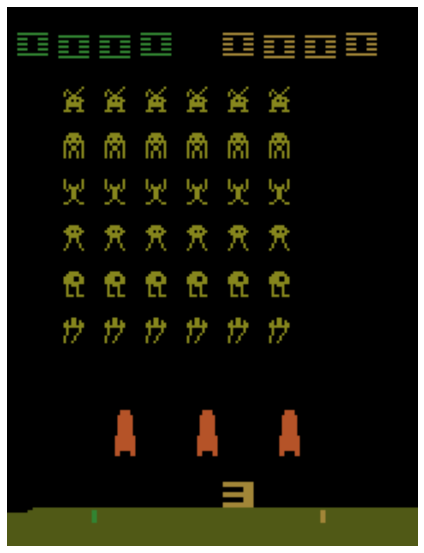

In [5]:
img = env.render(mode="rgb_array")

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")
save_fig("invader-plot")
plt.show()

In [6]:
from tf_agents.environments.wrappers import ActionRepeat
from gym.wrappers import TimeLimit
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

class AtariPreprocessingWithSkipStart(AtariPreprocessing):
    def skip_frames(self, num_skip):
        for _ in range(num_skip):
          super().step(0) # NOOP for num_skip steps
    def reset(self, **kwargs):
        obs = super().reset(**kwargs)
        self.skip_frames(40)
        return obs
    def step(self, action):
        lives_before_action = self.ale.lives()
        obs, rewards, done, info = super().step(action)
        if self.ale.lives() < lives_before_action and not done:
            self.skip_frames(40)
        return obs, rewards, done, info


repeating_env = ActionRepeat(env, times=4)
limited_repeating_env = suite_gym.load(
    "ALE/SpaceInvaders-v5",
    gym_env_wrappers=[lambda env: TimeLimit(env, max_episode_steps=10000)],
    env_wrappers=[lambda env: ActionRepeat(env, times=4)]
)
env = suite_gym.load(
    'ALE/SpaceInvaders-v5',
    max_episode_steps=27000,
    gym_env_wrappers=[AtariPreprocessingWithSkipStart, FrameStack4]
)

In [7]:
import numpy as np

def draw_obs(obs): #Draw the Observation Screen
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")


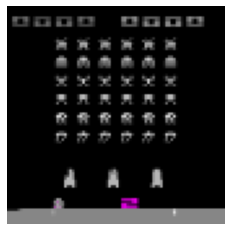

In [8]:
env.seed(32)

env.reset()
for _ in range(4): #Test control and get the trajectory
    time_step = env.step(3)

draw_obs(time_step.observation)
# save_fig('processed_invadar_game_pic')
plt.show()

In [9]:
from tf_agents.environments import TFPyEnvironment
import keras
import tensorflow as tf
from tf_agents.networks.q_network import QNetwork
from tf_agents.networks.actor_distribution_network import ActorDistributionNetwork

tf_env = TFPyEnvironment(env)

preprocessing_layer = keras.layers.Lambda(lambda obs: tf.cast(obs, np.float32) / 255.) #Default layer design from book
fc_layer_params = [512]
conv_layer_params = [(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params
)


In [10]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

train_steps = tf.Variable(0)
global_step = tf.compat.v1.train.get_or_create_global_step()
update_period = 4
optimizer = tf.keras.optimizers.RMSprop(learning_rate=2.5e-4, rho=0.95, momentum=0.0, epsilon=0.00001, centered=True)
epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0,
    decay_steps=250000 // update_period,
    end_learning_rate=0.01)
agent = DqnAgent(
    time_step_spec=tf_env.time_step_spec(),
    action_spec=tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    target_update_period=2000,
    td_errors_loss_fn=keras.losses.Huber(reduction="none"),
    gamma=0.99,
    train_step_counter=train_steps,
    epsilon_greedy=lambda:epsilon_fn(train_steps)
)
agent.initialize()

In [11]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.replay_buffers.py_hashed_replay_buffer import PyHashedReplayBuffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=500000
)

replay_buffer_observer = replay_buffer.add_batch

In [12]:
class ShowProgress():
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

In [13]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric()
]

In [14]:
from tf_agents.eval.metric_utils import log_metrics
import logging

logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


In [15]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period
)

In [16]:
collect_driver

In [17]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(), tf_env.action_spec())

init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000
)
final_time_step, final_policy_state = init_driver.run()

20000/20000

In [18]:
trajectories, buffer_info = next(iter(replay_buffer.as_dataset(
    sample_batch_size=2,
    num_steps=3,
    single_deterministic_pass=False)))
print(trajectories)
print(buffer_info)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Trajectory(
{'action': <tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[2, 2, 5],
       [1, 2, 1]], dtype=int64)>,
 'discount': <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 1., 1.],
       [1., 1., 1.]], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]])>,
 'observation': <tf.Tensor: shape=(2, 3, 84, 84, 4), dtype=uint8, numpy=
array([[[[[ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          ...,
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0]],

         [[ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          ...,
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0]],

         [[ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          ...,
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0]],

         ...,

         [[

In [19]:
print(trajectories._fields)

('step_type', 'observation', 'action', 'policy_info', 'next_step_type', 'reward', 'discount')


In [20]:
print('Shape of \'observation\': ', trajectories.observation.shape)
print('Shape of \'rewards\': ', trajectories.reward.shape)
print(trajectories.step_type.numpy())

Shape of 'observation':  (2, 3, 84, 84, 4)
Shape of 'rewards':  (2, 3)
[[1 1 1]
 [1 1 1]]


Saving figure sub_episode_plot


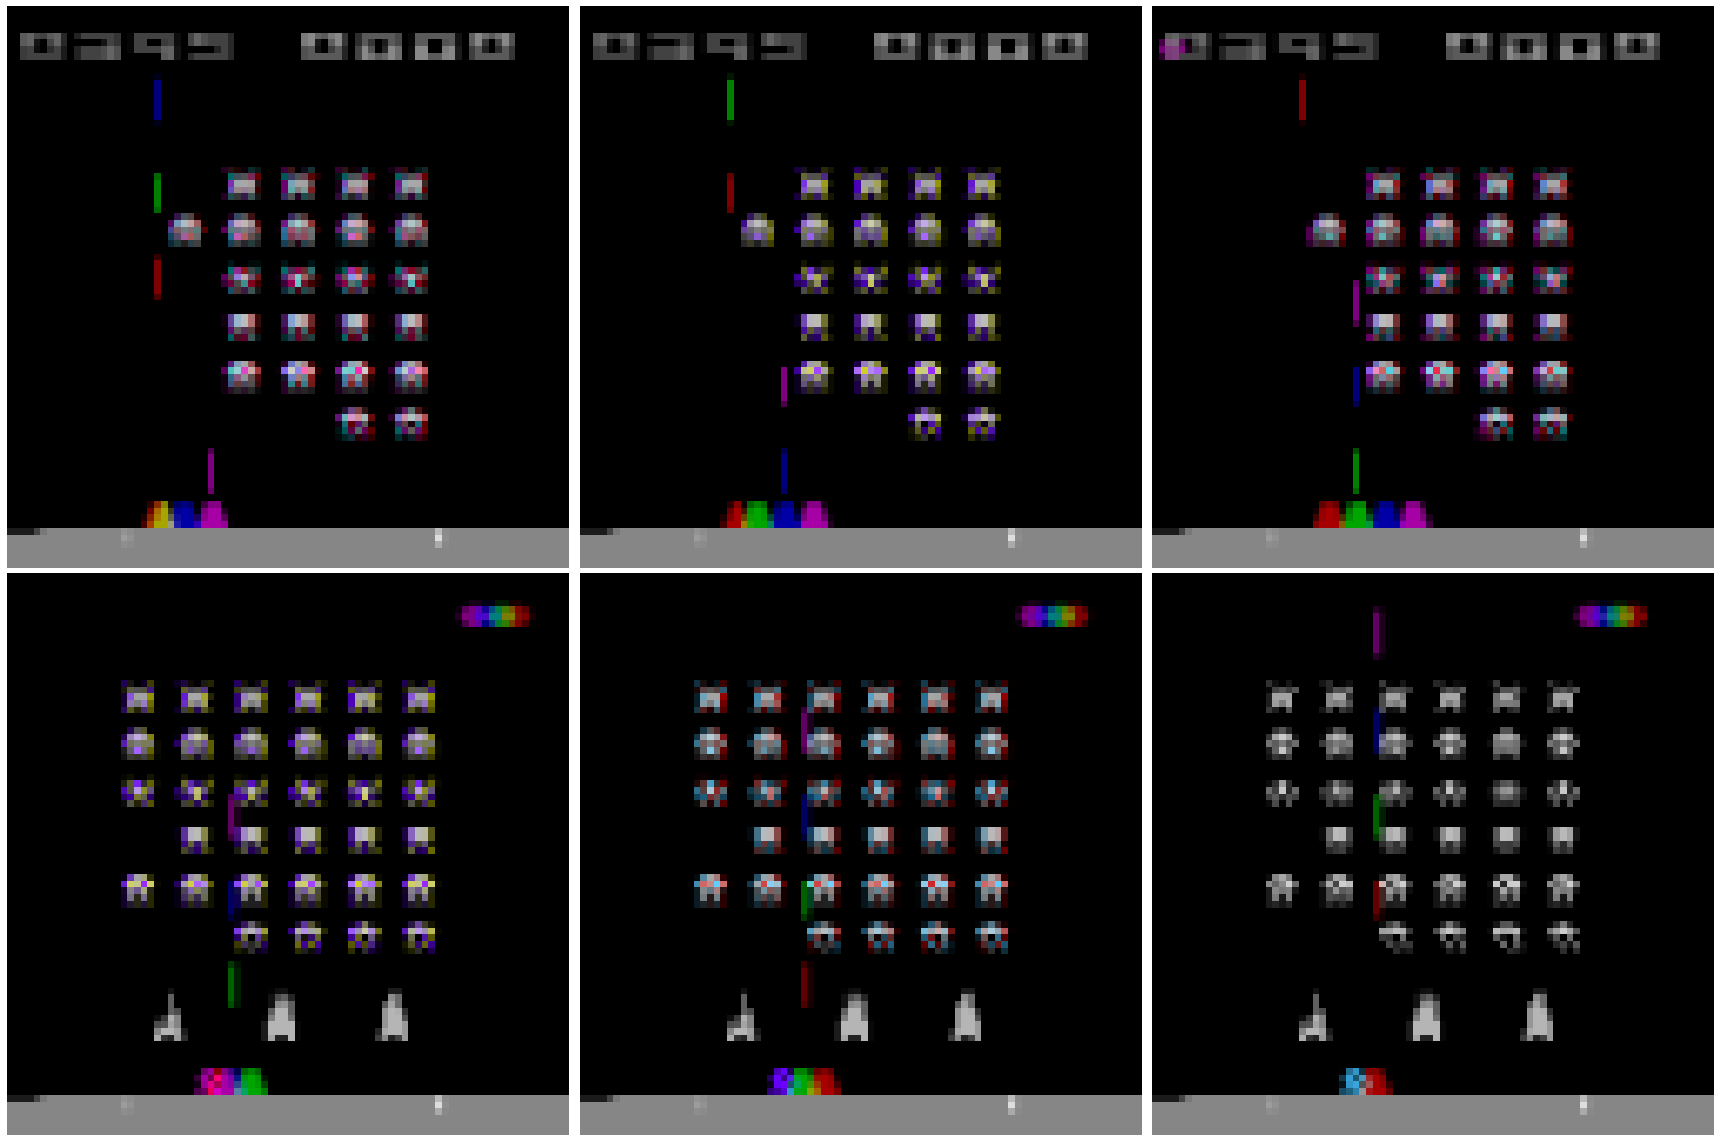

In [21]:
plt.figure(figsize=(24, 16))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row*3 + col+1)
        draw_obs(trajectories.observation[row, col].numpy())
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0.02)
save_fig('sub_episode_plot')
plt.show()

簡單印出其中兩個 Trajectories

In [22]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3).prefetch(3)

In [23]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)


In [24]:
# from tf_agents.utils import common

# global_step = tf.compat.v1.train.get_or_create_global_step()
# tempdir = 'D:/Workspace/Python/Self-Invader-agent'
# checkpoint_dir = os.path.join(tempdir, 'checkpoint')
# train_checkpointer = common.Checkpointer(
#     ckpt_dir=checkpoint_dir,
#     max_to_keep=1,
#     agent=agent,
#     policy=agent.policy,
#     replay_buffer=replay_buffer,
#     global_step=global_step
# )
# train_checkpointer.save()

In [25]:
def train_agent(n_iterations):
    time_step = None
    total_return = 0.0
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(iteration, train_loss.loss.numpy()), end="")
        if (iteration % 10000 == 0):
            # train_checkpointer.save(iteration)
            # saver.save('policy_%d' % iteration)
            log_metrics(train_metrics)

In [26]:
train_agent(400000)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 4
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


999 loss:0.64802

INFO:absl: 
		 NumberOfEpisodes = 81
		 EnvironmentSteps = 4004
		 AverageReturn = 60.5
		 AverageEpisodeLength = 52.099998474121094


1996 loss:0.36215

INFO:absl: 
		 NumberOfEpisodes = 166
		 EnvironmentSteps = 8004
		 AverageReturn = 25.5
		 AverageEpisodeLength = 34.599998474121094


2997 loss:1.48525

INFO:absl: 
		 NumberOfEpisodes = 251
		 EnvironmentSteps = 12004
		 AverageReturn = 29.5
		 AverageEpisodeLength = 38.79999923706055


3998 loss:0.98336

INFO:absl: 
		 NumberOfEpisodes = 347
		 EnvironmentSteps = 16004
		 AverageReturn = 39.0
		 AverageEpisodeLength = 39.20000076293945


4999 loss:0.67843

INFO:absl: 
		 NumberOfEpisodes = 436
		 EnvironmentSteps = 20004
		 AverageReturn = 50.5
		 AverageEpisodeLength = 37.70000076293945


6000 loss:1.78952

INFO:absl: 
		 NumberOfEpisodes = 513
		 EnvironmentSteps = 24004
		 AverageReturn = 50.5
		 AverageEpisodeLength = 48.0


6998 loss:1.42517

INFO:absl: 
		 NumberOfEpisodes = 611
		 EnvironmentSteps = 28004
		 AverageReturn = 39.5
		 AverageEpisodeLength = 35.400001525878906


7998 loss:0.42264

INFO:absl: 
		 NumberOfEpisodes = 697
		 EnvironmentSteps = 32004
		 AverageReturn = 48.0
		 AverageEpisodeLength = 41.0


8998 loss:2.09936

INFO:absl: 
		 NumberOfEpisodes = 773
		 EnvironmentSteps = 36004
		 AverageReturn = 84.0
		 AverageEpisodeLength = 53.0


9996 loss:1.21105

INFO:absl: 
		 NumberOfEpisodes = 868
		 EnvironmentSteps = 40004
		 AverageReturn = 35.0
		 AverageEpisodeLength = 34.0


10999 loss:0.40691

INFO:absl: 
		 NumberOfEpisodes = 960
		 EnvironmentSteps = 44004
		 AverageReturn = 37.5
		 AverageEpisodeLength = 35.400001525878906


12000 loss:1.88892

INFO:absl: 
		 NumberOfEpisodes = 1051
		 EnvironmentSteps = 48004
		 AverageReturn = 72.5
		 AverageEpisodeLength = 46.0


12999 loss:1.00707

INFO:absl: 
		 NumberOfEpisodes = 1140
		 EnvironmentSteps = 52004
		 AverageReturn = 125.5
		 AverageEpisodeLength = 60.20000076293945


13996 loss:0.81311

INFO:absl: 
		 NumberOfEpisodes = 1209
		 EnvironmentSteps = 56004
		 AverageReturn = 141.5
		 AverageEpisodeLength = 89.4000015258789


14999 loss:1.27193

INFO:absl: 
		 NumberOfEpisodes = 1296
		 EnvironmentSteps = 60004
		 AverageReturn = 44.5
		 AverageEpisodeLength = 39.5


15996 loss:0.70379

INFO:absl: 
		 NumberOfEpisodes = 1389
		 EnvironmentSteps = 64004
		 AverageReturn = 67.0
		 AverageEpisodeLength = 47.70000076293945


16999 loss:1.29164

INFO:absl: 
		 NumberOfEpisodes = 1486
		 EnvironmentSteps = 68004
		 AverageReturn = 82.0
		 AverageEpisodeLength = 53.20000076293945


17999 loss:1.20074

INFO:absl: 
		 NumberOfEpisodes = 1568
		 EnvironmentSteps = 72004
		 AverageReturn = 109.5
		 AverageEpisodeLength = 57.70000076293945


18996 loss:1.18293

INFO:absl: 
		 NumberOfEpisodes = 1644
		 EnvironmentSteps = 76004
		 AverageReturn = 133.0
		 AverageEpisodeLength = 57.099998474121094


19996 loss:4.99545

INFO:absl: 
		 NumberOfEpisodes = 1727
		 EnvironmentSteps = 80004
		 AverageReturn = 95.0
		 AverageEpisodeLength = 54.599998474121094


20998 loss:1.29638

INFO:absl: 
		 NumberOfEpisodes = 1804
		 EnvironmentSteps = 84004
		 AverageReturn = 110.0
		 AverageEpisodeLength = 55.29999923706055


21998 loss:1.60748

INFO:absl: 
		 NumberOfEpisodes = 1886
		 EnvironmentSteps = 88004
		 AverageReturn = 82.5
		 AverageEpisodeLength = 56.0


23000 loss:1.20437

INFO:absl: 
		 NumberOfEpisodes = 1965
		 EnvironmentSteps = 92004
		 AverageReturn = 89.5
		 AverageEpisodeLength = 43.900001525878906


23998 loss:1.56617

INFO:absl: 
		 NumberOfEpisodes = 2054
		 EnvironmentSteps = 96004
		 AverageReturn = 104.5
		 AverageEpisodeLength = 50.79999923706055


24998 loss:1.75017

INFO:absl: 
		 NumberOfEpisodes = 2142
		 EnvironmentSteps = 100004
		 AverageReturn = 60.5
		 AverageEpisodeLength = 35.79999923706055


26000 loss:3.06168

INFO:absl: 
		 NumberOfEpisodes = 2232
		 EnvironmentSteps = 104004
		 AverageReturn = 61.5
		 AverageEpisodeLength = 32.599998474121094


26998 loss:1.34979

INFO:absl: 
		 NumberOfEpisodes = 2321
		 EnvironmentSteps = 108004
		 AverageReturn = 98.0
		 AverageEpisodeLength = 51.5


27999 loss:1.52452

INFO:absl: 
		 NumberOfEpisodes = 2402
		 EnvironmentSteps = 112004
		 AverageReturn = 94.5
		 AverageEpisodeLength = 46.400001525878906


29000 loss:5.69369

INFO:absl: 
		 NumberOfEpisodes = 2488
		 EnvironmentSteps = 116004
		 AverageReturn = 60.5
		 AverageEpisodeLength = 39.20000076293945


29999 loss:1.78686

INFO:absl: 
		 NumberOfEpisodes = 2570
		 EnvironmentSteps = 120004
		 AverageReturn = 94.0
		 AverageEpisodeLength = 47.599998474121094


30998 loss:2.65591

INFO:absl: 
		 NumberOfEpisodes = 2643
		 EnvironmentSteps = 124004
		 AverageReturn = 126.5
		 AverageEpisodeLength = 53.70000076293945


31999 loss:1.60857

INFO:absl: 
		 NumberOfEpisodes = 2720
		 EnvironmentSteps = 128004
		 AverageReturn = 146.0
		 AverageEpisodeLength = 61.0


32999 loss:10.85303

INFO:absl: 
		 NumberOfEpisodes = 2799
		 EnvironmentSteps = 132004
		 AverageReturn = 182.0
		 AverageEpisodeLength = 51.900001525878906


33999 loss:2.58217

INFO:absl: 
		 NumberOfEpisodes = 2886
		 EnvironmentSteps = 136004
		 AverageReturn = 100.5
		 AverageEpisodeLength = 49.099998474121094


34999 loss:2.42454

INFO:absl: 
		 NumberOfEpisodes = 2957
		 EnvironmentSteps = 140004
		 AverageReturn = 114.0
		 AverageEpisodeLength = 45.29999923706055


35999 loss:1.61073

INFO:absl: 
		 NumberOfEpisodes = 3049
		 EnvironmentSteps = 144004
		 AverageReturn = 111.0
		 AverageEpisodeLength = 53.400001525878906


36999 loss:3.01809

INFO:absl: 
		 NumberOfEpisodes = 3123
		 EnvironmentSteps = 148004
		 AverageReturn = 150.0
		 AverageEpisodeLength = 58.900001525878906


37999 loss:1.89767

INFO:absl: 
		 NumberOfEpisodes = 3209
		 EnvironmentSteps = 152004
		 AverageReturn = 88.5
		 AverageEpisodeLength = 37.900001525878906


38997 loss:2.05029

INFO:absl: 
		 NumberOfEpisodes = 3286
		 EnvironmentSteps = 156004
		 AverageReturn = 176.5
		 AverageEpisodeLength = 66.9000015258789


39997 loss:6.78059

INFO:absl: 
		 NumberOfEpisodes = 3365
		 EnvironmentSteps = 160004
		 AverageReturn = 121.0
		 AverageEpisodeLength = 44.5


40998 loss:3.93928

INFO:absl: 
		 NumberOfEpisodes = 3435
		 EnvironmentSteps = 164004
		 AverageReturn = 118.5
		 AverageEpisodeLength = 47.29999923706055


41998 loss:2.56567

INFO:absl: 
		 NumberOfEpisodes = 3517
		 EnvironmentSteps = 168004
		 AverageReturn = 176.0
		 AverageEpisodeLength = 61.79999923706055


42998 loss:2.41895

INFO:absl: 
		 NumberOfEpisodes = 3593
		 EnvironmentSteps = 172004
		 AverageReturn = 91.5
		 AverageEpisodeLength = 38.400001525878906


43996 loss:2.39396

INFO:absl: 
		 NumberOfEpisodes = 3654
		 EnvironmentSteps = 176004
		 AverageReturn = 160.5
		 AverageEpisodeLength = 62.599998474121094


44999 loss:2.001460

INFO:absl: 
		 NumberOfEpisodes = 3725
		 EnvironmentSteps = 180004
		 AverageReturn = 96.5
		 AverageEpisodeLength = 39.400001525878906


45999 loss:4.499622

INFO:absl: 
		 NumberOfEpisodes = 3789
		 EnvironmentSteps = 184004
		 AverageReturn = 149.5
		 AverageEpisodeLength = 70.19999694824219


46996 loss:2.93854

INFO:absl: 
		 NumberOfEpisodes = 3847
		 EnvironmentSteps = 188004
		 AverageReturn = 182.5
		 AverageEpisodeLength = 76.5


47998 loss:2.65589

INFO:absl: 
		 NumberOfEpisodes = 3904
		 EnvironmentSteps = 192004
		 AverageReturn = 194.0
		 AverageEpisodeLength = 71.5999984741211


48996 loss:4.399026

INFO:absl: 
		 NumberOfEpisodes = 3969
		 EnvironmentSteps = 196004
		 AverageReturn = 187.0
		 AverageEpisodeLength = 57.5


49998 loss:2.33496

INFO:absl: 
		 NumberOfEpisodes = 4033
		 EnvironmentSteps = 200004
		 AverageReturn = 125.0
		 AverageEpisodeLength = 52.900001525878906


50999 loss:1.74685

INFO:absl: 
		 NumberOfEpisodes = 4102
		 EnvironmentSteps = 204004
		 AverageReturn = 166.0
		 AverageEpisodeLength = 55.400001525878906


51999 loss:2.908699

INFO:absl: 
		 NumberOfEpisodes = 4166
		 EnvironmentSteps = 208004
		 AverageReturn = 199.0
		 AverageEpisodeLength = 61.0


52999 loss:3.65405

INFO:absl: 
		 NumberOfEpisodes = 4235
		 EnvironmentSteps = 212004
		 AverageReturn = 156.0
		 AverageEpisodeLength = 51.400001525878906


53998 loss:2.134013

INFO:absl: 
		 NumberOfEpisodes = 4302
		 EnvironmentSteps = 216004
		 AverageReturn = 159.5
		 AverageEpisodeLength = 59.900001525878906


55000 loss:2.969536

INFO:absl: 
		 NumberOfEpisodes = 4379
		 EnvironmentSteps = 220004
		 AverageReturn = 161.0
		 AverageEpisodeLength = 47.0


55998 loss:5.170915

INFO:absl: 
		 NumberOfEpisodes = 4456
		 EnvironmentSteps = 224004
		 AverageReturn = 173.5
		 AverageEpisodeLength = 43.0


56998 loss:3.017420

INFO:absl: 
		 NumberOfEpisodes = 4528
		 EnvironmentSteps = 228004
		 AverageReturn = 215.5
		 AverageEpisodeLength = 65.19999694824219


57999 loss:2.390870

INFO:absl: 
		 NumberOfEpisodes = 4585
		 EnvironmentSteps = 232004
		 AverageReturn = 273.5
		 AverageEpisodeLength = 82.0999984741211


58998 loss:7.34763

INFO:absl: 
		 NumberOfEpisodes = 4650
		 EnvironmentSteps = 236004
		 AverageReturn = 212.0
		 AverageEpisodeLength = 65.9000015258789


60000 loss:3.567216

INFO:absl: 
		 NumberOfEpisodes = 4720
		 EnvironmentSteps = 240004
		 AverageReturn = 173.5
		 AverageEpisodeLength = 52.400001525878906


60998 loss:4.087007

INFO:absl: 
		 NumberOfEpisodes = 4786
		 EnvironmentSteps = 244004
		 AverageReturn = 240.0
		 AverageEpisodeLength = 70.5


61999 loss:4.445188

INFO:absl: 
		 NumberOfEpisodes = 4851
		 EnvironmentSteps = 248004
		 AverageReturn = 192.5
		 AverageEpisodeLength = 66.5999984741211


62998 loss:5.425805

INFO:absl: 
		 NumberOfEpisodes = 4929
		 EnvironmentSteps = 252004
		 AverageReturn = 157.5
		 AverageEpisodeLength = 48.599998474121094


63996 loss:7.99957

INFO:absl: 
		 NumberOfEpisodes = 4999
		 EnvironmentSteps = 256004
		 AverageReturn = 155.0
		 AverageEpisodeLength = 49.20000076293945


64996 loss:5.352774

INFO:absl: 
		 NumberOfEpisodes = 5061
		 EnvironmentSteps = 260004
		 AverageReturn = 207.0
		 AverageEpisodeLength = 60.79999923706055


65996 loss:3.018260

INFO:absl: 
		 NumberOfEpisodes = 5116
		 EnvironmentSteps = 264004
		 AverageReturn = 241.5
		 AverageEpisodeLength = 78.0


66998 loss:4.400865

INFO:absl: 
		 NumberOfEpisodes = 5182
		 EnvironmentSteps = 268004
		 AverageReturn = 217.0
		 AverageEpisodeLength = 62.0


67996 loss:2.786322

INFO:absl: 
		 NumberOfEpisodes = 5253
		 EnvironmentSteps = 272004
		 AverageReturn = 250.5
		 AverageEpisodeLength = 75.9000015258789


68998 loss:6.429088

INFO:absl: 
		 NumberOfEpisodes = 5312
		 EnvironmentSteps = 276004
		 AverageReturn = 166.5
		 AverageEpisodeLength = 51.400001525878906


69999 loss:3.34241

INFO:absl: 
		 NumberOfEpisodes = 5382
		 EnvironmentSteps = 280004
		 AverageReturn = 193.0
		 AverageEpisodeLength = 57.400001525878906


70996 loss:4.712817

INFO:absl: 
		 NumberOfEpisodes = 5441
		 EnvironmentSteps = 284004
		 AverageReturn = 243.5
		 AverageEpisodeLength = 75.0999984741211


71998 loss:3.746415

INFO:absl: 
		 NumberOfEpisodes = 5502
		 EnvironmentSteps = 288004
		 AverageReturn = 217.5
		 AverageEpisodeLength = 73.19999694824219


72999 loss:3.304257

INFO:absl: 
		 NumberOfEpisodes = 5561
		 EnvironmentSteps = 292004
		 AverageReturn = 109.0
		 AverageEpisodeLength = 37.20000076293945


73997 loss:5.431565

INFO:absl: 
		 NumberOfEpisodes = 5624
		 EnvironmentSteps = 296004
		 AverageReturn = 160.5
		 AverageEpisodeLength = 50.5


74997 loss:6.965729

INFO:absl: 
		 NumberOfEpisodes = 5679
		 EnvironmentSteps = 300004
		 AverageReturn = 228.0
		 AverageEpisodeLength = 79.30000305175781


75998 loss:3.307320

INFO:absl: 
		 NumberOfEpisodes = 5736
		 EnvironmentSteps = 304004
		 AverageReturn = 240.5
		 AverageEpisodeLength = 77.5999984741211


76996 loss:5.023622

INFO:absl: 
		 NumberOfEpisodes = 5795
		 EnvironmentSteps = 308004
		 AverageReturn = 190.0
		 AverageEpisodeLength = 55.70000076293945


77998 loss:3.049464

INFO:absl: 
		 NumberOfEpisodes = 5855
		 EnvironmentSteps = 312004
		 AverageReturn = 206.0
		 AverageEpisodeLength = 62.79999923706055


78999 loss:4.438576

INFO:absl: 
		 NumberOfEpisodes = 5919
		 EnvironmentSteps = 316004
		 AverageReturn = 192.0
		 AverageEpisodeLength = 53.900001525878906


79999 loss:11.05925

INFO:absl: 
		 NumberOfEpisodes = 5976
		 EnvironmentSteps = 320004
		 AverageReturn = 152.0
		 AverageEpisodeLength = 47.0


80997 loss:5.158519

INFO:absl: 
		 NumberOfEpisodes = 6031
		 EnvironmentSteps = 324004
		 AverageReturn = 237.5
		 AverageEpisodeLength = 78.0


81997 loss:3.152206

INFO:absl: 
		 NumberOfEpisodes = 6096
		 EnvironmentSteps = 328004
		 AverageReturn = 173.5
		 AverageEpisodeLength = 54.5


82998 loss:2.379986

INFO:absl: 
		 NumberOfEpisodes = 6158
		 EnvironmentSteps = 332004
		 AverageReturn = 225.0
		 AverageEpisodeLength = 66.19999694824219


84000 loss:6.714356

INFO:absl: 
		 NumberOfEpisodes = 6220
		 EnvironmentSteps = 336004
		 AverageReturn = 317.0
		 AverageEpisodeLength = 85.5


84998 loss:3.511170

INFO:absl: 
		 NumberOfEpisodes = 6282
		 EnvironmentSteps = 340004
		 AverageReturn = 157.5
		 AverageEpisodeLength = 48.599998474121094


85997 loss:5.882103

INFO:absl: 
		 NumberOfEpisodes = 6352
		 EnvironmentSteps = 344004
		 AverageReturn = 188.5
		 AverageEpisodeLength = 58.20000076293945


86996 loss:3.491875

INFO:absl: 
		 NumberOfEpisodes = 6413
		 EnvironmentSteps = 348004
		 AverageReturn = 141.5
		 AverageEpisodeLength = 47.0


87999 loss:4.651743

INFO:absl: 
		 NumberOfEpisodes = 6469
		 EnvironmentSteps = 352004
		 AverageReturn = 199.5
		 AverageEpisodeLength = 61.400001525878906


89000 loss:6.410452

INFO:absl: 
		 NumberOfEpisodes = 6519
		 EnvironmentSteps = 356004
		 AverageReturn = 304.0
		 AverageEpisodeLength = 89.4000015258789


89998 loss:9.092082

INFO:absl: 
		 NumberOfEpisodes = 6574
		 EnvironmentSteps = 360004
		 AverageReturn = 271.5
		 AverageEpisodeLength = 87.0


90997 loss:3.987564

INFO:absl: 
		 NumberOfEpisodes = 6633
		 EnvironmentSteps = 364004
		 AverageReturn = 294.5
		 AverageEpisodeLength = 86.19999694824219


91999 loss:3.864157

INFO:absl: 
		 NumberOfEpisodes = 6687
		 EnvironmentSteps = 368004
		 AverageReturn = 277.0
		 AverageEpisodeLength = 78.19999694824219


92997 loss:5.594490

INFO:absl: 
		 NumberOfEpisodes = 6741
		 EnvironmentSteps = 372004
		 AverageReturn = 241.0
		 AverageEpisodeLength = 66.5


93997 loss:3.922848

INFO:absl: 
		 NumberOfEpisodes = 6793
		 EnvironmentSteps = 376004
		 AverageReturn = 254.0
		 AverageEpisodeLength = 71.9000015258789


94998 loss:4.273102

INFO:absl: 
		 NumberOfEpisodes = 6845
		 EnvironmentSteps = 380004
		 AverageReturn = 256.0
		 AverageEpisodeLength = 77.0999984741211


95999 loss:6.347868

INFO:absl: 
		 NumberOfEpisodes = 6901
		 EnvironmentSteps = 384004
		 AverageReturn = 290.5
		 AverageEpisodeLength = 70.30000305175781


96997 loss:4.996716

INFO:absl: 
		 NumberOfEpisodes = 6953
		 EnvironmentSteps = 388004
		 AverageReturn = 211.0
		 AverageEpisodeLength = 61.099998474121094


97999 loss:6.280085

INFO:absl: 
		 NumberOfEpisodes = 7007
		 EnvironmentSteps = 392004
		 AverageReturn = 228.0
		 AverageEpisodeLength = 66.0


98999 loss:5.710328

INFO:absl: 
		 NumberOfEpisodes = 7051
		 EnvironmentSteps = 396004
		 AverageReturn = 301.0
		 AverageEpisodeLength = 79.4000015258789


99996 loss:4.222923

INFO:absl: 
		 NumberOfEpisodes = 7098
		 EnvironmentSteps = 400004
		 AverageReturn = 246.5
		 AverageEpisodeLength = 70.4000015258789


101000 loss:5.142353

INFO:absl: 
		 NumberOfEpisodes = 7151
		 EnvironmentSteps = 404004
		 AverageReturn = 263.0
		 AverageEpisodeLength = 77.69999694824219


101999 loss:7.037731

INFO:absl: 
		 NumberOfEpisodes = 7201
		 EnvironmentSteps = 408004
		 AverageReturn = 311.5
		 AverageEpisodeLength = 85.80000305175781


102999 loss:5.949233

INFO:absl: 
		 NumberOfEpisodes = 7256
		 EnvironmentSteps = 412004
		 AverageReturn = 259.5
		 AverageEpisodeLength = 60.5


103998 loss:4.861824

INFO:absl: 
		 NumberOfEpisodes = 7306
		 EnvironmentSteps = 416004
		 AverageReturn = 350.0
		 AverageEpisodeLength = 97.4000015258789


104996 loss:6.064571

INFO:absl: 
		 NumberOfEpisodes = 7360
		 EnvironmentSteps = 420004
		 AverageReturn = 298.0
		 AverageEpisodeLength = 80.69999694824219


106000 loss:5.573969

INFO:absl: 
		 NumberOfEpisodes = 7416
		 EnvironmentSteps = 424004
		 AverageReturn = 262.5
		 AverageEpisodeLength = 60.5


106996 loss:4.355511

INFO:absl: 
		 NumberOfEpisodes = 7468
		 EnvironmentSteps = 428004
		 AverageReturn = 274.0
		 AverageEpisodeLength = 80.9000015258789


107997 loss:2.739082

INFO:absl: 
		 NumberOfEpisodes = 7524
		 EnvironmentSteps = 432004
		 AverageReturn = 262.0
		 AverageEpisodeLength = 74.0999984741211


108997 loss:8.258297

INFO:absl: 
		 NumberOfEpisodes = 7571
		 EnvironmentSteps = 436004
		 AverageReturn = 323.5
		 AverageEpisodeLength = 91.5999984741211


109997 loss:5.425936

INFO:absl: 
		 NumberOfEpisodes = 7619
		 EnvironmentSteps = 440004
		 AverageReturn = 301.0
		 AverageEpisodeLength = 98.69999694824219


110996 loss:4.014596

INFO:absl: 
		 NumberOfEpisodes = 7676
		 EnvironmentSteps = 444004
		 AverageReturn = 229.5
		 AverageEpisodeLength = 66.5999984741211


111996 loss:5.834645

INFO:absl: 
		 NumberOfEpisodes = 7725
		 EnvironmentSteps = 448004
		 AverageReturn = 292.0
		 AverageEpisodeLength = 97.80000305175781


112996 loss:5.852068

INFO:absl: 
		 NumberOfEpisodes = 7779
		 EnvironmentSteps = 452004
		 AverageReturn = 286.0
		 AverageEpisodeLength = 75.69999694824219


113999 loss:7.793727

INFO:absl: 
		 NumberOfEpisodes = 7834
		 EnvironmentSteps = 456004
		 AverageReturn = 191.0
		 AverageEpisodeLength = 55.29999923706055


114997 loss:5.888590

INFO:absl: 
		 NumberOfEpisodes = 7885
		 EnvironmentSteps = 460004
		 AverageReturn = 280.0
		 AverageEpisodeLength = 83.0999984741211


115997 loss:5.068874

INFO:absl: 
		 NumberOfEpisodes = 7943
		 EnvironmentSteps = 464004
		 AverageReturn = 285.0
		 AverageEpisodeLength = 82.0


116999 loss:8.360859

INFO:absl: 
		 NumberOfEpisodes = 7998
		 EnvironmentSteps = 468004
		 AverageReturn = 235.0
		 AverageEpisodeLength = 64.9000015258789


117998 loss:7.419187

INFO:absl: 
		 NumberOfEpisodes = 8048
		 EnvironmentSteps = 472004
		 AverageReturn = 339.5
		 AverageEpisodeLength = 96.19999694824219


118997 loss:5.709525

INFO:absl: 
		 NumberOfEpisodes = 8094
		 EnvironmentSteps = 476004
		 AverageReturn = 253.5
		 AverageEpisodeLength = 77.0999984741211


119997 loss:9.392570

INFO:absl: 
		 NumberOfEpisodes = 8143
		 EnvironmentSteps = 480004
		 AverageReturn = 322.5
		 AverageEpisodeLength = 89.9000015258789


120997 loss:9.054905

INFO:absl: 
		 NumberOfEpisodes = 8187
		 EnvironmentSteps = 484004
		 AverageReturn = 349.5
		 AverageEpisodeLength = 105.0


121999 loss:7.746197

INFO:absl: 
		 NumberOfEpisodes = 8235
		 EnvironmentSteps = 488004
		 AverageReturn = 313.0
		 AverageEpisodeLength = 93.0


122997 loss:6.107785

INFO:absl: 
		 NumberOfEpisodes = 8285
		 EnvironmentSteps = 492004
		 AverageReturn = 325.0
		 AverageEpisodeLength = 95.5


123998 loss:4.614565

INFO:absl: 
		 NumberOfEpisodes = 8333
		 EnvironmentSteps = 496004
		 AverageReturn = 300.0
		 AverageEpisodeLength = 79.0


124999 loss:7.579229

INFO:absl: 
		 NumberOfEpisodes = 8376
		 EnvironmentSteps = 500004
		 AverageReturn = 287.0
		 AverageEpisodeLength = 82.19999694824219


125999 loss:8.218301

INFO:absl: 
		 NumberOfEpisodes = 8424
		 EnvironmentSteps = 504004
		 AverageReturn = 329.5
		 AverageEpisodeLength = 95.80000305175781


126999 loss:5.060099

INFO:absl: 
		 NumberOfEpisodes = 8476
		 EnvironmentSteps = 508004
		 AverageReturn = 244.0
		 AverageEpisodeLength = 69.0


127998 loss:4.516461

INFO:absl: 
		 NumberOfEpisodes = 8529
		 EnvironmentSteps = 512004
		 AverageReturn = 263.0
		 AverageEpisodeLength = 71.19999694824219


128997 loss:5.419138

INFO:absl: 
		 NumberOfEpisodes = 8576
		 EnvironmentSteps = 516004
		 AverageReturn = 157.5
		 AverageEpisodeLength = 57.400001525878906


129999 loss:6.905639

INFO:absl: 
		 NumberOfEpisodes = 8631
		 EnvironmentSteps = 520004
		 AverageReturn = 235.0
		 AverageEpisodeLength = 67.4000015258789


130996 loss:8.980312

INFO:absl: 
		 NumberOfEpisodes = 8682
		 EnvironmentSteps = 524004
		 AverageReturn = 318.0
		 AverageEpisodeLength = 94.30000305175781


131997 loss:6.877033

INFO:absl: 
		 NumberOfEpisodes = 8734
		 EnvironmentSteps = 528004
		 AverageReturn = 297.5
		 AverageEpisodeLength = 79.80000305175781


132997 loss:10.46785

INFO:absl: 
		 NumberOfEpisodes = 8781
		 EnvironmentSteps = 532004
		 AverageReturn = 329.5
		 AverageEpisodeLength = 80.5999984741211


133996 loss:6.800839

INFO:absl: 
		 NumberOfEpisodes = 8836
		 EnvironmentSteps = 536004
		 AverageReturn = 321.5
		 AverageEpisodeLength = 88.0999984741211


134996 loss:5.093400

INFO:absl: 
		 NumberOfEpisodes = 8890
		 EnvironmentSteps = 540004
		 AverageReturn = 288.0
		 AverageEpisodeLength = 76.4000015258789


135998 loss:3.854534

INFO:absl: 
		 NumberOfEpisodes = 8950
		 EnvironmentSteps = 544004
		 AverageReturn = 276.0
		 AverageEpisodeLength = 80.0999984741211


136996 loss:5.903620

INFO:absl: 
		 NumberOfEpisodes = 9001
		 EnvironmentSteps = 548004
		 AverageReturn = 310.5
		 AverageEpisodeLength = 80.30000305175781


138000 loss:13.86394

INFO:absl: 
		 NumberOfEpisodes = 9053
		 EnvironmentSteps = 552004
		 AverageReturn = 246.0
		 AverageEpisodeLength = 75.19999694824219


139000 loss:11.22704

INFO:absl: 
		 NumberOfEpisodes = 9105
		 EnvironmentSteps = 556004
		 AverageReturn = 244.0
		 AverageEpisodeLength = 66.69999694824219


140000 loss:12.95872

INFO:absl: 
		 NumberOfEpisodes = 9158
		 EnvironmentSteps = 560004
		 AverageReturn = 183.5
		 AverageEpisodeLength = 45.79999923706055


140997 loss:6.619722

INFO:absl: 
		 NumberOfEpisodes = 9205
		 EnvironmentSteps = 564004
		 AverageReturn = 310.0
		 AverageEpisodeLength = 93.9000015258789


141999 loss:3.576067

INFO:absl: 
		 NumberOfEpisodes = 9253
		 EnvironmentSteps = 568004
		 AverageReturn = 297.5
		 AverageEpisodeLength = 87.9000015258789


142997 loss:3.856686

INFO:absl: 
		 NumberOfEpisodes = 9299
		 EnvironmentSteps = 572004
		 AverageReturn = 378.0
		 AverageEpisodeLength = 111.30000305175781


143998 loss:3.260418

INFO:absl: 
		 NumberOfEpisodes = 9348
		 EnvironmentSteps = 576004
		 AverageReturn = 273.0
		 AverageEpisodeLength = 83.30000305175781


144998 loss:2.740601

INFO:absl: 
		 NumberOfEpisodes = 9394
		 EnvironmentSteps = 580004
		 AverageReturn = 390.5
		 AverageEpisodeLength = 106.0999984741211


145999 loss:11.81430

INFO:absl: 
		 NumberOfEpisodes = 9447
		 EnvironmentSteps = 584004
		 AverageReturn = 257.0
		 AverageEpisodeLength = 69.0999984741211


147000 loss:4.877272

INFO:absl: 
		 NumberOfEpisodes = 9490
		 EnvironmentSteps = 588004
		 AverageReturn = 352.0
		 AverageEpisodeLength = 99.0


147996 loss:7.950698

INFO:absl: 
		 NumberOfEpisodes = 9534
		 EnvironmentSteps = 592004
		 AverageReturn = 339.5
		 AverageEpisodeLength = 89.5999984741211


148999 loss:9.894109

INFO:absl: 
		 NumberOfEpisodes = 9583
		 EnvironmentSteps = 596004
		 AverageReturn = 207.5
		 AverageEpisodeLength = 61.099998474121094


149996 loss:5.116548

INFO:absl: 
		 NumberOfEpisodes = 9633
		 EnvironmentSteps = 600004
		 AverageReturn = 294.5
		 AverageEpisodeLength = 89.0999984741211


150999 loss:6.183580

INFO:absl: 
		 NumberOfEpisodes = 9679
		 EnvironmentSteps = 604004
		 AverageReturn = 269.0
		 AverageEpisodeLength = 75.5


151998 loss:3.699443

INFO:absl: 
		 NumberOfEpisodes = 9727
		 EnvironmentSteps = 608004
		 AverageReturn = 290.5
		 AverageEpisodeLength = 85.30000305175781


152998 loss:5.694624

INFO:absl: 
		 NumberOfEpisodes = 9782
		 EnvironmentSteps = 612004
		 AverageReturn = 267.0
		 AverageEpisodeLength = 76.69999694824219


153999 loss:8.775087

INFO:absl: 
		 NumberOfEpisodes = 9837
		 EnvironmentSteps = 616004
		 AverageReturn = 270.5
		 AverageEpisodeLength = 71.9000015258789


154998 loss:10.23248

INFO:absl: 
		 NumberOfEpisodes = 9890
		 EnvironmentSteps = 620004
		 AverageReturn = 267.5
		 AverageEpisodeLength = 80.0


155997 loss:5.747512

INFO:absl: 
		 NumberOfEpisodes = 9935
		 EnvironmentSteps = 624004
		 AverageReturn = 312.5
		 AverageEpisodeLength = 86.80000305175781


156998 loss:17.73841

INFO:absl: 
		 NumberOfEpisodes = 9985
		 EnvironmentSteps = 628004
		 AverageReturn = 321.5
		 AverageEpisodeLength = 78.4000015258789


157998 loss:7.523239

INFO:absl: 
		 NumberOfEpisodes = 10028
		 EnvironmentSteps = 632004
		 AverageReturn = 349.0
		 AverageEpisodeLength = 111.80000305175781


158999 loss:5.874800

INFO:absl: 
		 NumberOfEpisodes = 10080
		 EnvironmentSteps = 636004
		 AverageReturn = 315.5
		 AverageEpisodeLength = 82.5999984741211


159999 loss:7.606268

INFO:absl: 
		 NumberOfEpisodes = 10131
		 EnvironmentSteps = 640004
		 AverageReturn = 313.5
		 AverageEpisodeLength = 93.5999984741211


160997 loss:5.286920

INFO:absl: 
		 NumberOfEpisodes = 10180
		 EnvironmentSteps = 644004
		 AverageReturn = 332.5
		 AverageEpisodeLength = 87.30000305175781


161997 loss:13.44912

INFO:absl: 
		 NumberOfEpisodes = 10228
		 EnvironmentSteps = 648004
		 AverageReturn = 270.0
		 AverageEpisodeLength = 77.4000015258789


162996 loss:5.147476

INFO:absl: 
		 NumberOfEpisodes = 10272
		 EnvironmentSteps = 652004
		 AverageReturn = 421.5
		 AverageEpisodeLength = 119.4000015258789


163998 loss:2.927053

INFO:absl: 
		 NumberOfEpisodes = 10322
		 EnvironmentSteps = 656004
		 AverageReturn = 316.0
		 AverageEpisodeLength = 89.30000305175781


164998 loss:9.474450

INFO:absl: 
		 NumberOfEpisodes = 10372
		 EnvironmentSteps = 660004
		 AverageReturn = 247.0
		 AverageEpisodeLength = 64.0


165999 loss:8.037420

INFO:absl: 
		 NumberOfEpisodes = 10424
		 EnvironmentSteps = 664004
		 AverageReturn = 272.0
		 AverageEpisodeLength = 68.0999984741211


166997 loss:5.447120

INFO:absl: 
		 NumberOfEpisodes = 10467
		 EnvironmentSteps = 668004
		 AverageReturn = 260.0
		 AverageEpisodeLength = 72.0999984741211


167996 loss:4.515983

INFO:absl: 
		 NumberOfEpisodes = 10517
		 EnvironmentSteps = 672004
		 AverageReturn = 340.0
		 AverageEpisodeLength = 89.0999984741211


168996 loss:6.212979

INFO:absl: 
		 NumberOfEpisodes = 10562
		 EnvironmentSteps = 676004
		 AverageReturn = 351.0
		 AverageEpisodeLength = 99.5


170000 loss:10.86607

INFO:absl: 
		 NumberOfEpisodes = 10605
		 EnvironmentSteps = 680004
		 AverageReturn = 320.0
		 AverageEpisodeLength = 85.4000015258789


171000 loss:5.747816

INFO:absl: 
		 NumberOfEpisodes = 10649
		 EnvironmentSteps = 684004
		 AverageReturn = 331.5
		 AverageEpisodeLength = 93.19999694824219


171996 loss:10.29538

INFO:absl: 
		 NumberOfEpisodes = 10700
		 EnvironmentSteps = 688004
		 AverageReturn = 268.5
		 AverageEpisodeLength = 77.4000015258789


172996 loss:13.40366

INFO:absl: 
		 NumberOfEpisodes = 10749
		 EnvironmentSteps = 692004
		 AverageReturn = 347.0
		 AverageEpisodeLength = 82.80000305175781


173996 loss:4.048368

INFO:absl: 
		 NumberOfEpisodes = 10800
		 EnvironmentSteps = 696004
		 AverageReturn = 245.0
		 AverageEpisodeLength = 63.79999923706055


174998 loss:4.476469

INFO:absl: 
		 NumberOfEpisodes = 10849
		 EnvironmentSteps = 700004
		 AverageReturn = 348.0
		 AverageEpisodeLength = 89.5999984741211


175998 loss:12.00903

INFO:absl: 
		 NumberOfEpisodes = 10895
		 EnvironmentSteps = 704004
		 AverageReturn = 326.5
		 AverageEpisodeLength = 81.5999984741211


176999 loss:2.484010

INFO:absl: 
		 NumberOfEpisodes = 10946
		 EnvironmentSteps = 708004
		 AverageReturn = 140.5
		 AverageEpisodeLength = 42.79999923706055


177997 loss:6.313773

INFO:absl: 
		 NumberOfEpisodes = 10999
		 EnvironmentSteps = 712004
		 AverageReturn = 312.0
		 AverageEpisodeLength = 88.0


178997 loss:5.755185

INFO:absl: 
		 NumberOfEpisodes = 11048
		 EnvironmentSteps = 716004
		 AverageReturn = 317.0
		 AverageEpisodeLength = 83.9000015258789


179999 loss:4.261375

INFO:absl: 
		 NumberOfEpisodes = 11096
		 EnvironmentSteps = 720004
		 AverageReturn = 231.5
		 AverageEpisodeLength = 71.0


180998 loss:9.591315

INFO:absl: 
		 NumberOfEpisodes = 11143
		 EnvironmentSteps = 724004
		 AverageReturn = 354.0
		 AverageEpisodeLength = 86.0


181999 loss:5.773106

INFO:absl: 
		 NumberOfEpisodes = 11187
		 EnvironmentSteps = 728004
		 AverageReturn = 317.0
		 AverageEpisodeLength = 88.9000015258789


182997 loss:8.243247

INFO:absl: 
		 NumberOfEpisodes = 11230
		 EnvironmentSteps = 732004
		 AverageReturn = 288.0
		 AverageEpisodeLength = 68.5


183999 loss:6.555879

INFO:absl: 
		 NumberOfEpisodes = 11271
		 EnvironmentSteps = 736004
		 AverageReturn = 392.0
		 AverageEpisodeLength = 110.4000015258789


184997 loss:13.27061

INFO:absl: 
		 NumberOfEpisodes = 11315
		 EnvironmentSteps = 740004
		 AverageReturn = 343.0
		 AverageEpisodeLength = 90.5999984741211


185997 loss:2.838407

INFO:absl: 
		 NumberOfEpisodes = 11363
		 EnvironmentSteps = 744004
		 AverageReturn = 344.5
		 AverageEpisodeLength = 90.5999984741211


186999 loss:5.706387

INFO:absl: 
		 NumberOfEpisodes = 11403
		 EnvironmentSteps = 748004
		 AverageReturn = 296.0
		 AverageEpisodeLength = 79.19999694824219


187996 loss:14.53264

INFO:absl: 
		 NumberOfEpisodes = 11446
		 EnvironmentSteps = 752004
		 AverageReturn = 274.5
		 AverageEpisodeLength = 78.0


188998 loss:8.868127

INFO:absl: 
		 NumberOfEpisodes = 11494
		 EnvironmentSteps = 756004
		 AverageReturn = 275.0
		 AverageEpisodeLength = 89.30000305175781


189999 loss:2.893832

INFO:absl: 
		 NumberOfEpisodes = 11532
		 EnvironmentSteps = 760004
		 AverageReturn = 407.5
		 AverageEpisodeLength = 108.19999694824219


190996 loss:11.25870

INFO:absl: 
		 NumberOfEpisodes = 11580
		 EnvironmentSteps = 764004
		 AverageReturn = 313.5
		 AverageEpisodeLength = 83.69999694824219


191996 loss:7.000912

INFO:absl: 
		 NumberOfEpisodes = 11625
		 EnvironmentSteps = 768004
		 AverageReturn = 311.5
		 AverageEpisodeLength = 80.30000305175781


192999 loss:6.512534

INFO:absl: 
		 NumberOfEpisodes = 11674
		 EnvironmentSteps = 772004
		 AverageReturn = 342.5
		 AverageEpisodeLength = 84.4000015258789


193996 loss:6.060298

INFO:absl: 
		 NumberOfEpisodes = 11725
		 EnvironmentSteps = 776004
		 AverageReturn = 186.0
		 AverageEpisodeLength = 50.099998474121094


194997 loss:6.525621

INFO:absl: 
		 NumberOfEpisodes = 11766
		 EnvironmentSteps = 780004
		 AverageReturn = 450.0
		 AverageEpisodeLength = 112.5999984741211


195997 loss:8.796861

INFO:absl: 
		 NumberOfEpisodes = 11807
		 EnvironmentSteps = 784004
		 AverageReturn = 343.5
		 AverageEpisodeLength = 101.80000305175781


196998 loss:10.24739

INFO:absl: 
		 NumberOfEpisodes = 11850
		 EnvironmentSteps = 788004
		 AverageReturn = 248.5
		 AverageEpisodeLength = 71.4000015258789


197999 loss:8.284051

INFO:absl: 
		 NumberOfEpisodes = 11896
		 EnvironmentSteps = 792004
		 AverageReturn = 324.5
		 AverageEpisodeLength = 98.0999984741211


198999 loss:11.80022

INFO:absl: 
		 NumberOfEpisodes = 11941
		 EnvironmentSteps = 796004
		 AverageReturn = 338.0
		 AverageEpisodeLength = 88.9000015258789


199998 loss:6.187946

INFO:absl: 
		 NumberOfEpisodes = 11980
		 EnvironmentSteps = 800004
		 AverageReturn = 308.0
		 AverageEpisodeLength = 89.5


200997 loss:3.524896

INFO:absl: 
		 NumberOfEpisodes = 12029
		 EnvironmentSteps = 804004
		 AverageReturn = 319.0
		 AverageEpisodeLength = 81.0


202000 loss:8.930841

INFO:absl: 
		 NumberOfEpisodes = 12078
		 EnvironmentSteps = 808004
		 AverageReturn = 322.5
		 AverageEpisodeLength = 90.0999984741211


202996 loss:10.16453

INFO:absl: 
		 NumberOfEpisodes = 12121
		 EnvironmentSteps = 812004
		 AverageReturn = 356.5
		 AverageEpisodeLength = 90.69999694824219


203996 loss:6.223588

INFO:absl: 
		 NumberOfEpisodes = 12161
		 EnvironmentSteps = 816004
		 AverageReturn = 347.0
		 AverageEpisodeLength = 95.80000305175781


204998 loss:6.009089

INFO:absl: 
		 NumberOfEpisodes = 12199
		 EnvironmentSteps = 820004
		 AverageReturn = 365.0
		 AverageEpisodeLength = 98.0


205997 loss:6.545837

INFO:absl: 
		 NumberOfEpisodes = 12242
		 EnvironmentSteps = 824004
		 AverageReturn = 321.5
		 AverageEpisodeLength = 92.9000015258789


206996 loss:6.240794

INFO:absl: 
		 NumberOfEpisodes = 12287
		 EnvironmentSteps = 828004
		 AverageReturn = 303.5
		 AverageEpisodeLength = 85.5999984741211


207997 loss:8.139752

INFO:absl: 
		 NumberOfEpisodes = 12334
		 EnvironmentSteps = 832004
		 AverageReturn = 290.0
		 AverageEpisodeLength = 86.0


208996 loss:10.95665

INFO:absl: 
		 NumberOfEpisodes = 12378
		 EnvironmentSteps = 836004
		 AverageReturn = 328.0
		 AverageEpisodeLength = 91.30000305175781


209999 loss:13.17544

INFO:absl: 
		 NumberOfEpisodes = 12427
		 EnvironmentSteps = 840004
		 AverageReturn = 288.5
		 AverageEpisodeLength = 78.0


210996 loss:7.004487

INFO:absl: 
		 NumberOfEpisodes = 12477
		 EnvironmentSteps = 844004
		 AverageReturn = 320.0
		 AverageEpisodeLength = 87.69999694824219


211996 loss:5.855364

INFO:absl: 
		 NumberOfEpisodes = 12528
		 EnvironmentSteps = 848004
		 AverageReturn = 341.5
		 AverageEpisodeLength = 83.9000015258789


212999 loss:5.807638

INFO:absl: 
		 NumberOfEpisodes = 12577
		 EnvironmentSteps = 852004
		 AverageReturn = 282.5
		 AverageEpisodeLength = 76.9000015258789


214000 loss:4.284125

INFO:absl: 
		 NumberOfEpisodes = 12618
		 EnvironmentSteps = 856004
		 AverageReturn = 365.0
		 AverageEpisodeLength = 100.69999694824219


214998 loss:7.217014

INFO:absl: 
		 NumberOfEpisodes = 12661
		 EnvironmentSteps = 860004
		 AverageReturn = 380.0
		 AverageEpisodeLength = 105.80000305175781


215998 loss:13.67849

INFO:absl: 
		 NumberOfEpisodes = 12709
		 EnvironmentSteps = 864004
		 AverageReturn = 342.0
		 AverageEpisodeLength = 93.5999984741211


216996 loss:4.980898

INFO:absl: 
		 NumberOfEpisodes = 12763
		 EnvironmentSteps = 868004
		 AverageReturn = 289.0
		 AverageEpisodeLength = 78.4000015258789


217999 loss:13.50056

INFO:absl: 
		 NumberOfEpisodes = 12810
		 EnvironmentSteps = 872004
		 AverageReturn = 300.5
		 AverageEpisodeLength = 74.5


218998 loss:7.770120

INFO:absl: 
		 NumberOfEpisodes = 12849
		 EnvironmentSteps = 876004
		 AverageReturn = 279.0
		 AverageEpisodeLength = 71.69999694824219


219998 loss:10.20028

INFO:absl: 
		 NumberOfEpisodes = 12895
		 EnvironmentSteps = 880004
		 AverageReturn = 244.5
		 AverageEpisodeLength = 70.5


220998 loss:8.290109

INFO:absl: 
		 NumberOfEpisodes = 12940
		 EnvironmentSteps = 884004
		 AverageReturn = 370.0
		 AverageEpisodeLength = 102.69999694824219


221999 loss:7.001928

INFO:absl: 
		 NumberOfEpisodes = 12996
		 EnvironmentSteps = 888004
		 AverageReturn = 346.5
		 AverageEpisodeLength = 92.4000015258789


222999 loss:8.864768

INFO:absl: 
		 NumberOfEpisodes = 13045
		 EnvironmentSteps = 892004
		 AverageReturn = 299.0
		 AverageEpisodeLength = 92.69999694824219


223997 loss:7.312706

INFO:absl: 
		 NumberOfEpisodes = 13088
		 EnvironmentSteps = 896004
		 AverageReturn = 373.0
		 AverageEpisodeLength = 99.30000305175781


224996 loss:7.386346

INFO:absl: 
		 NumberOfEpisodes = 13132
		 EnvironmentSteps = 900004
		 AverageReturn = 344.0
		 AverageEpisodeLength = 87.5


225999 loss:9.366345

INFO:absl: 
		 NumberOfEpisodes = 13181
		 EnvironmentSteps = 904004
		 AverageReturn = 288.5
		 AverageEpisodeLength = 79.69999694824219


226998 loss:6.753413

INFO:absl: 
		 NumberOfEpisodes = 13229
		 EnvironmentSteps = 908004
		 AverageReturn = 291.5
		 AverageEpisodeLength = 76.5


227998 loss:6.546183

INFO:absl: 
		 NumberOfEpisodes = 13271
		 EnvironmentSteps = 912004
		 AverageReturn = 400.5
		 AverageEpisodeLength = 98.19999694824219


228998 loss:12.36611

INFO:absl: 
		 NumberOfEpisodes = 13317
		 EnvironmentSteps = 916004
		 AverageReturn = 385.5
		 AverageEpisodeLength = 91.69999694824219


229999 loss:5.068829

INFO:absl: 
		 NumberOfEpisodes = 13373
		 EnvironmentSteps = 920004
		 AverageReturn = 231.5
		 AverageEpisodeLength = 67.30000305175781


230997 loss:2.828108

INFO:absl: 
		 NumberOfEpisodes = 13416
		 EnvironmentSteps = 924004
		 AverageReturn = 380.5
		 AverageEpisodeLength = 100.30000305175781


231999 loss:7.844686

INFO:absl: 
		 NumberOfEpisodes = 13456
		 EnvironmentSteps = 928004
		 AverageReturn = 321.5
		 AverageEpisodeLength = 82.30000305175781


232998 loss:5.102163

INFO:absl: 
		 NumberOfEpisodes = 13504
		 EnvironmentSteps = 932004
		 AverageReturn = 263.5
		 AverageEpisodeLength = 62.20000076293945


233997 loss:7.107118

INFO:absl: 
		 NumberOfEpisodes = 13545
		 EnvironmentSteps = 936004
		 AverageReturn = 312.5
		 AverageEpisodeLength = 91.0


234999 loss:3.964900

INFO:absl: 
		 NumberOfEpisodes = 13595
		 EnvironmentSteps = 940004
		 AverageReturn = 249.5
		 AverageEpisodeLength = 70.69999694824219


235998 loss:6.299301

INFO:absl: 
		 NumberOfEpisodes = 13643
		 EnvironmentSteps = 944004
		 AverageReturn = 266.0
		 AverageEpisodeLength = 71.0999984741211


236999 loss:7.975721

INFO:absl: 
		 NumberOfEpisodes = 13692
		 EnvironmentSteps = 948004
		 AverageReturn = 303.5
		 AverageEpisodeLength = 91.69999694824219


237999 loss:7.617508

INFO:absl: 
		 NumberOfEpisodes = 13731
		 EnvironmentSteps = 952004
		 AverageReturn = 397.5
		 AverageEpisodeLength = 104.0


238999 loss:9.738565

INFO:absl: 
		 NumberOfEpisodes = 13778
		 EnvironmentSteps = 956004
		 AverageReturn = 319.0
		 AverageEpisodeLength = 86.69999694824219


239997 loss:12.58823

INFO:absl: 
		 NumberOfEpisodes = 13818
		 EnvironmentSteps = 960004
		 AverageReturn = 405.0
		 AverageEpisodeLength = 104.69999694824219


240998 loss:6.111041

INFO:absl: 
		 NumberOfEpisodes = 13863
		 EnvironmentSteps = 964004
		 AverageReturn = 450.0
		 AverageEpisodeLength = 120.30000305175781


241998 loss:5.078924

INFO:absl: 
		 NumberOfEpisodes = 13907
		 EnvironmentSteps = 968004
		 AverageReturn = 336.0
		 AverageEpisodeLength = 94.69999694824219


242999 loss:4.598505

INFO:absl: 
		 NumberOfEpisodes = 13954
		 EnvironmentSteps = 972004
		 AverageReturn = 352.5
		 AverageEpisodeLength = 98.19999694824219


243998 loss:4.150019

INFO:absl: 
		 NumberOfEpisodes = 13998
		 EnvironmentSteps = 976004
		 AverageReturn = 276.5
		 AverageEpisodeLength = 67.30000305175781


244999 loss:4.334015

INFO:absl: 
		 NumberOfEpisodes = 14041
		 EnvironmentSteps = 980004
		 AverageReturn = 374.0
		 AverageEpisodeLength = 97.80000305175781


246000 loss:7.883683

INFO:absl: 
		 NumberOfEpisodes = 14085
		 EnvironmentSteps = 984004
		 AverageReturn = 377.0
		 AverageEpisodeLength = 100.19999694824219


246996 loss:13.06359

INFO:absl: 
		 NumberOfEpisodes = 14128
		 EnvironmentSteps = 988004
		 AverageReturn = 293.5
		 AverageEpisodeLength = 82.0


247999 loss:4.378616

INFO:absl: 
		 NumberOfEpisodes = 14175
		 EnvironmentSteps = 992004
		 AverageReturn = 247.5
		 AverageEpisodeLength = 64.5999984741211


248996 loss:7.238930

INFO:absl: 
		 NumberOfEpisodes = 14228
		 EnvironmentSteps = 996004
		 AverageReturn = 138.0
		 AverageEpisodeLength = 40.099998474121094


249998 loss:12.14027

INFO:absl: 
		 NumberOfEpisodes = 14293
		 EnvironmentSteps = 1000004
		 AverageReturn = 138.0
		 AverageEpisodeLength = 40.29999923706055


251000 loss:12.26548

INFO:absl: 
		 NumberOfEpisodes = 14336
		 EnvironmentSteps = 1004004
		 AverageReturn = 381.5
		 AverageEpisodeLength = 99.0


252000 loss:6.413397

INFO:absl: 
		 NumberOfEpisodes = 14379
		 EnvironmentSteps = 1008004
		 AverageReturn = 391.0
		 AverageEpisodeLength = 101.5


252998 loss:9.908394

INFO:absl: 
		 NumberOfEpisodes = 14423
		 EnvironmentSteps = 1012004
		 AverageReturn = 331.0
		 AverageEpisodeLength = 80.0999984741211


253997 loss:6.736204

INFO:absl: 
		 NumberOfEpisodes = 14471
		 EnvironmentSteps = 1016004
		 AverageReturn = 319.0
		 AverageEpisodeLength = 85.5


254996 loss:6.246465

INFO:absl: 
		 NumberOfEpisodes = 14515
		 EnvironmentSteps = 1020004
		 AverageReturn = 358.0
		 AverageEpisodeLength = 95.5


255999 loss:2.461637

INFO:absl: 
		 NumberOfEpisodes = 14559
		 EnvironmentSteps = 1024004
		 AverageReturn = 331.0
		 AverageEpisodeLength = 85.5


256998 loss:7.939466

INFO:absl: 
		 NumberOfEpisodes = 14605
		 EnvironmentSteps = 1028004
		 AverageReturn = 292.0
		 AverageEpisodeLength = 80.0999984741211


257999 loss:8.813215

INFO:absl: 
		 NumberOfEpisodes = 14647
		 EnvironmentSteps = 1032004
		 AverageReturn = 397.5
		 AverageEpisodeLength = 110.0999984741211


258999 loss:6.315004

INFO:absl: 
		 NumberOfEpisodes = 14697
		 EnvironmentSteps = 1036004
		 AverageReturn = 217.5
		 AverageEpisodeLength = 62.0


259998 loss:4.472755

INFO:absl: 
		 NumberOfEpisodes = 14747
		 EnvironmentSteps = 1040004
		 AverageReturn = 288.5
		 AverageEpisodeLength = 74.69999694824219


260996 loss:16.09726

INFO:absl: 
		 NumberOfEpisodes = 14790
		 EnvironmentSteps = 1044004
		 AverageReturn = 387.0
		 AverageEpisodeLength = 98.80000305175781


261999 loss:4.799003

INFO:absl: 
		 NumberOfEpisodes = 14833
		 EnvironmentSteps = 1048004
		 AverageReturn = 286.0
		 AverageEpisodeLength = 77.69999694824219


262997 loss:7.822273

INFO:absl: 
		 NumberOfEpisodes = 14868
		 EnvironmentSteps = 1052004
		 AverageReturn = 374.5
		 AverageEpisodeLength = 91.9000015258789


263999 loss:6.194208

INFO:absl: 
		 NumberOfEpisodes = 14912
		 EnvironmentSteps = 1056004
		 AverageReturn = 347.0
		 AverageEpisodeLength = 94.80000305175781


264996 loss:6.913372

INFO:absl: 
		 NumberOfEpisodes = 14955
		 EnvironmentSteps = 1060004
		 AverageReturn = 336.5
		 AverageEpisodeLength = 82.0999984741211


265997 loss:14.14456

INFO:absl: 
		 NumberOfEpisodes = 14995
		 EnvironmentSteps = 1064004
		 AverageReturn = 365.0
		 AverageEpisodeLength = 94.9000015258789


266998 loss:6.261324

INFO:absl: 
		 NumberOfEpisodes = 15039
		 EnvironmentSteps = 1068004
		 AverageReturn = 343.0
		 AverageEpisodeLength = 89.5


267998 loss:5.430948

INFO:absl: 
		 NumberOfEpisodes = 15084
		 EnvironmentSteps = 1072004
		 AverageReturn = 303.5
		 AverageEpisodeLength = 78.0999984741211


269000 loss:9.020436

INFO:absl: 
		 NumberOfEpisodes = 15142
		 EnvironmentSteps = 1076004
		 AverageReturn = 264.0
		 AverageEpisodeLength = 67.4000015258789


269999 loss:4.198257

INFO:absl: 
		 NumberOfEpisodes = 15185
		 EnvironmentSteps = 1080004
		 AverageReturn = 307.0
		 AverageEpisodeLength = 78.5999984741211


271000 loss:10.50159

INFO:absl: 
		 NumberOfEpisodes = 15232
		 EnvironmentSteps = 1084004
		 AverageReturn = 367.0
		 AverageEpisodeLength = 96.0


271999 loss:11.06785

INFO:absl: 
		 NumberOfEpisodes = 15273
		 EnvironmentSteps = 1088004
		 AverageReturn = 284.5
		 AverageEpisodeLength = 68.69999694824219


272999 loss:5.183443

INFO:absl: 
		 NumberOfEpisodes = 15313
		 EnvironmentSteps = 1092004
		 AverageReturn = 417.5
		 AverageEpisodeLength = 115.0999984741211


274000 loss:7.918751

INFO:absl: 
		 NumberOfEpisodes = 15366
		 EnvironmentSteps = 1096004
		 AverageReturn = 310.5
		 AverageEpisodeLength = 84.5999984741211


274997 loss:3.677801

INFO:absl: 
		 NumberOfEpisodes = 15414
		 EnvironmentSteps = 1100004
		 AverageReturn = 413.0
		 AverageEpisodeLength = 109.80000305175781


276000 loss:9.739512

INFO:absl: 
		 NumberOfEpisodes = 15463
		 EnvironmentSteps = 1104004
		 AverageReturn = 342.5
		 AverageEpisodeLength = 84.69999694824219


276998 loss:3.257471

INFO:absl: 
		 NumberOfEpisodes = 15506
		 EnvironmentSteps = 1108004
		 AverageReturn = 284.5
		 AverageEpisodeLength = 80.0


277996 loss:3.003519

INFO:absl: 
		 NumberOfEpisodes = 15548
		 EnvironmentSteps = 1112004
		 AverageReturn = 380.0
		 AverageEpisodeLength = 94.80000305175781


278998 loss:7.282092

INFO:absl: 
		 NumberOfEpisodes = 15591
		 EnvironmentSteps = 1116004
		 AverageReturn = 432.5
		 AverageEpisodeLength = 112.9000015258789


279998 loss:3.575711

INFO:absl: 
		 NumberOfEpisodes = 15636
		 EnvironmentSteps = 1120004
		 AverageReturn = 358.0
		 AverageEpisodeLength = 99.80000305175781


280998 loss:6.640918

INFO:absl: 
		 NumberOfEpisodes = 15679
		 EnvironmentSteps = 1124004
		 AverageReturn = 410.0
		 AverageEpisodeLength = 101.5999984741211


281998 loss:8.967141

INFO:absl: 
		 NumberOfEpisodes = 15725
		 EnvironmentSteps = 1128004
		 AverageReturn = 406.0
		 AverageEpisodeLength = 117.5


282996 loss:14.95996

INFO:absl: 
		 NumberOfEpisodes = 15772
		 EnvironmentSteps = 1132004
		 AverageReturn = 324.0
		 AverageEpisodeLength = 76.30000305175781


283999 loss:8.116377

INFO:absl: 
		 NumberOfEpisodes = 15816
		 EnvironmentSteps = 1136004
		 AverageReturn = 329.5
		 AverageEpisodeLength = 77.0


284999 loss:8.456400

INFO:absl: 
		 NumberOfEpisodes = 15856
		 EnvironmentSteps = 1140004
		 AverageReturn = 471.0
		 AverageEpisodeLength = 127.30000305175781


285998 loss:10.45070

INFO:absl: 
		 NumberOfEpisodes = 15903
		 EnvironmentSteps = 1144004
		 AverageReturn = 396.5
		 AverageEpisodeLength = 95.5


286996 loss:5.680555

INFO:absl: 
		 NumberOfEpisodes = 15951
		 EnvironmentSteps = 1148004
		 AverageReturn = 316.5
		 AverageEpisodeLength = 84.80000305175781


287996 loss:4.885333

INFO:absl: 
		 NumberOfEpisodes = 16000
		 EnvironmentSteps = 1152004
		 AverageReturn = 306.5
		 AverageEpisodeLength = 79.19999694824219


288996 loss:3.887319

INFO:absl: 
		 NumberOfEpisodes = 16042
		 EnvironmentSteps = 1156004
		 AverageReturn = 356.0
		 AverageEpisodeLength = 103.0


289998 loss:4.641848

INFO:absl: 
		 NumberOfEpisodes = 16082
		 EnvironmentSteps = 1160004
		 AverageReturn = 360.0
		 AverageEpisodeLength = 98.4000015258789


290998 loss:8.412290

INFO:absl: 
		 NumberOfEpisodes = 16128
		 EnvironmentSteps = 1164004
		 AverageReturn = 368.5
		 AverageEpisodeLength = 101.5


291997 loss:5.232280

INFO:absl: 
		 NumberOfEpisodes = 16178
		 EnvironmentSteps = 1168004
		 AverageReturn = 291.0
		 AverageEpisodeLength = 85.0


292998 loss:7.560381

INFO:absl: 
		 NumberOfEpisodes = 16229
		 EnvironmentSteps = 1172004
		 AverageReturn = 368.0
		 AverageEpisodeLength = 91.30000305175781


293997 loss:2.936457

INFO:absl: 
		 NumberOfEpisodes = 16273
		 EnvironmentSteps = 1176004
		 AverageReturn = 437.0
		 AverageEpisodeLength = 107.5999984741211


294997 loss:15.30107

INFO:absl: 
		 NumberOfEpisodes = 16321
		 EnvironmentSteps = 1180004
		 AverageReturn = 269.0
		 AverageEpisodeLength = 67.9000015258789


295996 loss:2.243994

INFO:absl: 
		 NumberOfEpisodes = 16365
		 EnvironmentSteps = 1184004
		 AverageReturn = 326.0
		 AverageEpisodeLength = 80.9000015258789


296997 loss:7.184192

INFO:absl: 
		 NumberOfEpisodes = 16406
		 EnvironmentSteps = 1188004
		 AverageReturn = 411.0
		 AverageEpisodeLength = 107.5


297998 loss:7.123049

INFO:absl: 
		 NumberOfEpisodes = 16450
		 EnvironmentSteps = 1192004
		 AverageReturn = 386.0
		 AverageEpisodeLength = 97.4000015258789


298998 loss:12.78583

INFO:absl: 
		 NumberOfEpisodes = 16489
		 EnvironmentSteps = 1196004
		 AverageReturn = 305.0
		 AverageEpisodeLength = 81.19999694824219


299999 loss:4.473536

INFO:absl: 
		 NumberOfEpisodes = 16528
		 EnvironmentSteps = 1200004
		 AverageReturn = 296.0
		 AverageEpisodeLength = 66.4000015258789


300996 loss:3.561482

INFO:absl: 
		 NumberOfEpisodes = 16570
		 EnvironmentSteps = 1204004
		 AverageReturn = 318.5
		 AverageEpisodeLength = 86.5999984741211


301999 loss:5.280951

INFO:absl: 
		 NumberOfEpisodes = 16612
		 EnvironmentSteps = 1208004
		 AverageReturn = 390.0
		 AverageEpisodeLength = 101.9000015258789


302998 loss:9.281914

INFO:absl: 
		 NumberOfEpisodes = 16651
		 EnvironmentSteps = 1212004
		 AverageReturn = 354.0
		 AverageEpisodeLength = 92.5999984741211


304000 loss:14.77030

INFO:absl: 
		 NumberOfEpisodes = 16701
		 EnvironmentSteps = 1216004
		 AverageReturn = 297.5
		 AverageEpisodeLength = 76.5999984741211


304997 loss:9.409235

INFO:absl: 
		 NumberOfEpisodes = 16748
		 EnvironmentSteps = 1220004
		 AverageReturn = 380.0
		 AverageEpisodeLength = 103.80000305175781


305998 loss:6.096587

INFO:absl: 
		 NumberOfEpisodes = 16796
		 EnvironmentSteps = 1224004
		 AverageReturn = 275.0
		 AverageEpisodeLength = 73.0


306998 loss:5.953313

INFO:absl: 
		 NumberOfEpisodes = 16836
		 EnvironmentSteps = 1228004
		 AverageReturn = 404.5
		 AverageEpisodeLength = 110.9000015258789


307998 loss:3.213556

INFO:absl: 
		 NumberOfEpisodes = 16871
		 EnvironmentSteps = 1232004
		 AverageReturn = 459.0
		 AverageEpisodeLength = 121.30000305175781


309000 loss:6.905805

INFO:absl: 
		 NumberOfEpisodes = 16911
		 EnvironmentSteps = 1236004
		 AverageReturn = 418.5
		 AverageEpisodeLength = 113.5999984741211


309998 loss:5.874389

INFO:absl: 
		 NumberOfEpisodes = 16955
		 EnvironmentSteps = 1240004
		 AverageReturn = 277.5
		 AverageEpisodeLength = 72.5999984741211


310998 loss:7.469923

INFO:absl: 
		 NumberOfEpisodes = 17003
		 EnvironmentSteps = 1244004
		 AverageReturn = 268.5
		 AverageEpisodeLength = 66.5999984741211


311997 loss:4.114672

INFO:absl: 
		 NumberOfEpisodes = 17050
		 EnvironmentSteps = 1248004
		 AverageReturn = 361.5
		 AverageEpisodeLength = 96.5999984741211


312997 loss:4.989182

INFO:absl: 
		 NumberOfEpisodes = 17093
		 EnvironmentSteps = 1252004
		 AverageReturn = 273.0
		 AverageEpisodeLength = 73.0999984741211


313997 loss:3.958346

INFO:absl: 
		 NumberOfEpisodes = 17138
		 EnvironmentSteps = 1256004
		 AverageReturn = 304.0
		 AverageEpisodeLength = 79.69999694824219


314996 loss:9.349637

INFO:absl: 
		 NumberOfEpisodes = 17180
		 EnvironmentSteps = 1260004
		 AverageReturn = 365.5
		 AverageEpisodeLength = 81.0


315996 loss:16.22713

INFO:absl: 
		 NumberOfEpisodes = 17227
		 EnvironmentSteps = 1264004
		 AverageReturn = 337.0
		 AverageEpisodeLength = 82.30000305175781


316996 loss:6.698900

INFO:absl: 
		 NumberOfEpisodes = 17274
		 EnvironmentSteps = 1268004
		 AverageReturn = 292.5
		 AverageEpisodeLength = 76.30000305175781


317999 loss:7.187564

INFO:absl: 
		 NumberOfEpisodes = 17314
		 EnvironmentSteps = 1272004
		 AverageReturn = 463.0
		 AverageEpisodeLength = 110.30000305175781


318999 loss:8.992778

INFO:absl: 
		 NumberOfEpisodes = 17358
		 EnvironmentSteps = 1276004
		 AverageReturn = 256.0
		 AverageEpisodeLength = 71.80000305175781


319997 loss:6.174708

INFO:absl: 
		 NumberOfEpisodes = 17403
		 EnvironmentSteps = 1280004
		 AverageReturn = 323.5
		 AverageEpisodeLength = 82.5


320998 loss:3.609511

INFO:absl: 
		 NumberOfEpisodes = 17447
		 EnvironmentSteps = 1284004
		 AverageReturn = 453.5
		 AverageEpisodeLength = 113.69999694824219


321998 loss:7.545571

INFO:absl: 
		 NumberOfEpisodes = 17484
		 EnvironmentSteps = 1288004
		 AverageReturn = 325.0
		 AverageEpisodeLength = 86.5


323000 loss:12.55513

INFO:absl: 
		 NumberOfEpisodes = 17524
		 EnvironmentSteps = 1292004
		 AverageReturn = 390.0
		 AverageEpisodeLength = 97.4000015258789


323997 loss:8.261107

INFO:absl: 
		 NumberOfEpisodes = 17567
		 EnvironmentSteps = 1296004
		 AverageReturn = 411.5
		 AverageEpisodeLength = 100.19999694824219


324997 loss:11.15081

INFO:absl: 
		 NumberOfEpisodes = 17607
		 EnvironmentSteps = 1300004
		 AverageReturn = 343.5
		 AverageEpisodeLength = 85.4000015258789


325998 loss:6.449279

INFO:absl: 
		 NumberOfEpisodes = 17647
		 EnvironmentSteps = 1304004
		 AverageReturn = 391.0
		 AverageEpisodeLength = 101.9000015258789


326996 loss:10.16981

INFO:absl: 
		 NumberOfEpisodes = 17694
		 EnvironmentSteps = 1308004
		 AverageReturn = 382.0
		 AverageEpisodeLength = 92.5999984741211


327999 loss:2.891468

INFO:absl: 
		 NumberOfEpisodes = 17733
		 EnvironmentSteps = 1312004
		 AverageReturn = 394.0
		 AverageEpisodeLength = 108.30000305175781


328999 loss:7.269265

INFO:absl: 
		 NumberOfEpisodes = 17771
		 EnvironmentSteps = 1316004
		 AverageReturn = 420.5
		 AverageEpisodeLength = 110.69999694824219


329997 loss:10.59910

INFO:absl: 
		 NumberOfEpisodes = 17807
		 EnvironmentSteps = 1320004
		 AverageReturn = 416.5
		 AverageEpisodeLength = 106.69999694824219


331000 loss:4.193140

INFO:absl: 
		 NumberOfEpisodes = 17848
		 EnvironmentSteps = 1324004
		 AverageReturn = 367.5
		 AverageEpisodeLength = 100.5


331996 loss:18.10202

INFO:absl: 
		 NumberOfEpisodes = 17897
		 EnvironmentSteps = 1328004
		 AverageReturn = 268.0
		 AverageEpisodeLength = 67.5999984741211


332996 loss:3.570262

INFO:absl: 
		 NumberOfEpisodes = 17939
		 EnvironmentSteps = 1332004
		 AverageReturn = 411.5
		 AverageEpisodeLength = 99.19999694824219


334000 loss:5.895993

INFO:absl: 
		 NumberOfEpisodes = 17981
		 EnvironmentSteps = 1336004
		 AverageReturn = 375.5
		 AverageEpisodeLength = 93.5999984741211


334998 loss:3.352682

INFO:absl: 
		 NumberOfEpisodes = 18025
		 EnvironmentSteps = 1340004
		 AverageReturn = 412.0
		 AverageEpisodeLength = 106.4000015258789


335997 loss:6.470035

INFO:absl: 
		 NumberOfEpisodes = 18078
		 EnvironmentSteps = 1344004
		 AverageReturn = 307.0
		 AverageEpisodeLength = 80.19999694824219


336999 loss:6.917086

INFO:absl: 
		 NumberOfEpisodes = 18121
		 EnvironmentSteps = 1348004
		 AverageReturn = 422.5
		 AverageEpisodeLength = 103.9000015258789


337999 loss:4.751594

INFO:absl: 
		 NumberOfEpisodes = 18169
		 EnvironmentSteps = 1352004
		 AverageReturn = 342.5
		 AverageEpisodeLength = 90.0999984741211


338998 loss:9.712555

INFO:absl: 
		 NumberOfEpisodes = 18216
		 EnvironmentSteps = 1356004
		 AverageReturn = 357.0
		 AverageEpisodeLength = 93.9000015258789


340000 loss:5.837431

INFO:absl: 
		 NumberOfEpisodes = 18253
		 EnvironmentSteps = 1360004
		 AverageReturn = 430.0
		 AverageEpisodeLength = 121.0999984741211


340999 loss:6.339527

INFO:absl: 
		 NumberOfEpisodes = 18293
		 EnvironmentSteps = 1364004
		 AverageReturn = 335.0
		 AverageEpisodeLength = 91.80000305175781


341996 loss:18.74009

INFO:absl: 
		 NumberOfEpisodes = 18335
		 EnvironmentSteps = 1368004
		 AverageReturn = 310.5
		 AverageEpisodeLength = 79.5999984741211


342999 loss:8.623070

INFO:absl: 
		 NumberOfEpisodes = 18381
		 EnvironmentSteps = 1372004
		 AverageReturn = 327.0
		 AverageEpisodeLength = 82.5999984741211


343998 loss:10.41417

INFO:absl: 
		 NumberOfEpisodes = 18425
		 EnvironmentSteps = 1376004
		 AverageReturn = 300.5
		 AverageEpisodeLength = 74.19999694824219


344998 loss:7.651043

INFO:absl: 
		 NumberOfEpisodes = 18468
		 EnvironmentSteps = 1380004
		 AverageReturn = 344.5
		 AverageEpisodeLength = 89.5999984741211


345996 loss:9.380875

INFO:absl: 
		 NumberOfEpisodes = 18510
		 EnvironmentSteps = 1384004
		 AverageReturn = 330.5
		 AverageEpisodeLength = 89.9000015258789


346996 loss:8.601822

INFO:absl: 
		 NumberOfEpisodes = 18551
		 EnvironmentSteps = 1388004
		 AverageReturn = 413.5
		 AverageEpisodeLength = 106.0


347997 loss:6.207820

INFO:absl: 
		 NumberOfEpisodes = 18591
		 EnvironmentSteps = 1392004
		 AverageReturn = 403.5
		 AverageEpisodeLength = 111.5999984741211


348998 loss:12.77776

INFO:absl: 
		 NumberOfEpisodes = 18635
		 EnvironmentSteps = 1396004
		 AverageReturn = 425.0
		 AverageEpisodeLength = 108.5


349998 loss:8.176810

INFO:absl: 
		 NumberOfEpisodes = 18680
		 EnvironmentSteps = 1400004
		 AverageReturn = 365.0
		 AverageEpisodeLength = 93.0


350996 loss:7.206470

INFO:absl: 
		 NumberOfEpisodes = 18726
		 EnvironmentSteps = 1404004
		 AverageReturn = 397.0
		 AverageEpisodeLength = 96.0


352000 loss:8.839653

INFO:absl: 
		 NumberOfEpisodes = 18768
		 EnvironmentSteps = 1408004
		 AverageReturn = 315.0
		 AverageEpisodeLength = 85.0999984741211


352999 loss:11.35671

INFO:absl: 
		 NumberOfEpisodes = 18814
		 EnvironmentSteps = 1412004
		 AverageReturn = 354.0
		 AverageEpisodeLength = 97.4000015258789


353998 loss:4.273865

INFO:absl: 
		 NumberOfEpisodes = 18852
		 EnvironmentSteps = 1416004
		 AverageReturn = 459.5
		 AverageEpisodeLength = 111.80000305175781


354997 loss:10.69842

INFO:absl: 
		 NumberOfEpisodes = 18899
		 EnvironmentSteps = 1420004
		 AverageReturn = 303.5
		 AverageEpisodeLength = 80.19999694824219


355997 loss:8.316145

INFO:absl: 
		 NumberOfEpisodes = 18941
		 EnvironmentSteps = 1424004
		 AverageReturn = 397.0
		 AverageEpisodeLength = 107.0999984741211


356997 loss:9.050830

INFO:absl: 
		 NumberOfEpisodes = 18984
		 EnvironmentSteps = 1428004
		 AverageReturn = 350.0
		 AverageEpisodeLength = 85.9000015258789


357999 loss:11.75831

INFO:absl: 
		 NumberOfEpisodes = 19020
		 EnvironmentSteps = 1432004
		 AverageReturn = 404.0
		 AverageEpisodeLength = 115.80000305175781


358998 loss:9.993351

INFO:absl: 
		 NumberOfEpisodes = 19065
		 EnvironmentSteps = 1436004
		 AverageReturn = 417.0
		 AverageEpisodeLength = 102.69999694824219


359997 loss:8.546094

INFO:absl: 
		 NumberOfEpisodes = 19108
		 EnvironmentSteps = 1440004
		 AverageReturn = 305.5
		 AverageEpisodeLength = 83.0


360997 loss:7.209367

INFO:absl: 
		 NumberOfEpisodes = 19156
		 EnvironmentSteps = 1444004
		 AverageReturn = 302.0
		 AverageEpisodeLength = 79.0


361999 loss:9.876324

INFO:absl: 
		 NumberOfEpisodes = 19198
		 EnvironmentSteps = 1448004
		 AverageReturn = 424.0
		 AverageEpisodeLength = 107.5


362997 loss:3.801116

INFO:absl: 
		 NumberOfEpisodes = 19238
		 EnvironmentSteps = 1452004
		 AverageReturn = 320.0
		 AverageEpisodeLength = 85.9000015258789


363996 loss:4.818335

INFO:absl: 
		 NumberOfEpisodes = 19279
		 EnvironmentSteps = 1456004
		 AverageReturn = 292.5
		 AverageEpisodeLength = 78.5


364998 loss:9.469106

INFO:absl: 
		 NumberOfEpisodes = 19321
		 EnvironmentSteps = 1460004
		 AverageReturn = 300.5
		 AverageEpisodeLength = 80.30000305175781


365999 loss:2.738239

INFO:absl: 
		 NumberOfEpisodes = 19361
		 EnvironmentSteps = 1464004
		 AverageReturn = 404.5
		 AverageEpisodeLength = 114.4000015258789


366999 loss:12.05056

INFO:absl: 
		 NumberOfEpisodes = 19409
		 EnvironmentSteps = 1468004
		 AverageReturn = 387.5
		 AverageEpisodeLength = 95.80000305175781


367999 loss:2.966453

INFO:absl: 
		 NumberOfEpisodes = 19458
		 EnvironmentSteps = 1472004
		 AverageReturn = 384.0
		 AverageEpisodeLength = 99.4000015258789


368997 loss:12.54110

INFO:absl: 
		 NumberOfEpisodes = 19503
		 EnvironmentSteps = 1476004
		 AverageReturn = 299.0
		 AverageEpisodeLength = 81.4000015258789


369997 loss:4.477382

INFO:absl: 
		 NumberOfEpisodes = 19547
		 EnvironmentSteps = 1480004
		 AverageReturn = 403.5
		 AverageEpisodeLength = 98.5


370997 loss:2.448452

INFO:absl: 
		 NumberOfEpisodes = 19592
		 EnvironmentSteps = 1484004
		 AverageReturn = 342.0
		 AverageEpisodeLength = 89.0


371997 loss:3.589812

INFO:absl: 
		 NumberOfEpisodes = 19632
		 EnvironmentSteps = 1488004
		 AverageReturn = 331.0
		 AverageEpisodeLength = 84.30000305175781


372996 loss:24.62192

INFO:absl: 
		 NumberOfEpisodes = 19674
		 EnvironmentSteps = 1492004
		 AverageReturn = 323.5
		 AverageEpisodeLength = 89.69999694824219


373999 loss:8.181819

INFO:absl: 
		 NumberOfEpisodes = 19715
		 EnvironmentSteps = 1496004
		 AverageReturn = 290.5
		 AverageEpisodeLength = 71.80000305175781


374997 loss:4.310344

INFO:absl: 
		 NumberOfEpisodes = 19753
		 EnvironmentSteps = 1500004
		 AverageReturn = 447.0
		 AverageEpisodeLength = 110.19999694824219


375999 loss:13.07316

INFO:absl: 
		 NumberOfEpisodes = 19796
		 EnvironmentSteps = 1504004
		 AverageReturn = 375.5
		 AverageEpisodeLength = 96.4000015258789


376997 loss:3.432829

INFO:absl: 
		 NumberOfEpisodes = 19837
		 EnvironmentSteps = 1508004
		 AverageReturn = 392.5
		 AverageEpisodeLength = 93.30000305175781


378000 loss:16.65551

INFO:absl: 
		 NumberOfEpisodes = 19875
		 EnvironmentSteps = 1512004
		 AverageReturn = 401.0
		 AverageEpisodeLength = 111.0


378999 loss:8.010999

INFO:absl: 
		 NumberOfEpisodes = 19920
		 EnvironmentSteps = 1516004
		 AverageReturn = 377.5
		 AverageEpisodeLength = 92.80000305175781


379996 loss:7.124350

INFO:absl: 
		 NumberOfEpisodes = 19961
		 EnvironmentSteps = 1520004
		 AverageReturn = 437.5
		 AverageEpisodeLength = 115.80000305175781


380999 loss:9.652944

INFO:absl: 
		 NumberOfEpisodes = 20004
		 EnvironmentSteps = 1524004
		 AverageReturn = 353.0
		 AverageEpisodeLength = 89.19999694824219


382000 loss:10.35422

INFO:absl: 
		 NumberOfEpisodes = 20042
		 EnvironmentSteps = 1528004
		 AverageReturn = 376.5
		 AverageEpisodeLength = 109.19999694824219


382996 loss:9.225167

INFO:absl: 
		 NumberOfEpisodes = 20090
		 EnvironmentSteps = 1532004
		 AverageReturn = 355.5
		 AverageEpisodeLength = 78.5


383997 loss:9.664867

INFO:absl: 
		 NumberOfEpisodes = 20133
		 EnvironmentSteps = 1536004
		 AverageReturn = 431.5
		 AverageEpisodeLength = 108.0999984741211


384998 loss:12.04874

INFO:absl: 
		 NumberOfEpisodes = 20176
		 EnvironmentSteps = 1540004
		 AverageReturn = 343.5
		 AverageEpisodeLength = 93.4000015258789


385998 loss:5.650897

INFO:absl: 
		 NumberOfEpisodes = 20216
		 EnvironmentSteps = 1544004
		 AverageReturn = 400.5
		 AverageEpisodeLength = 105.4000015258789


386997 loss:4.202450

INFO:absl: 
		 NumberOfEpisodes = 20252
		 EnvironmentSteps = 1548004
		 AverageReturn = 412.5
		 AverageEpisodeLength = 103.5999984741211


388000 loss:6.187082

INFO:absl: 
		 NumberOfEpisodes = 20290
		 EnvironmentSteps = 1552004
		 AverageReturn = 437.5
		 AverageEpisodeLength = 112.9000015258789


388997 loss:3.708290

INFO:absl: 
		 NumberOfEpisodes = 20330
		 EnvironmentSteps = 1556004
		 AverageReturn = 398.5
		 AverageEpisodeLength = 100.30000305175781


390000 loss:12.17976

INFO:absl: 
		 NumberOfEpisodes = 20367
		 EnvironmentSteps = 1560004
		 AverageReturn = 460.5
		 AverageEpisodeLength = 119.80000305175781


390997 loss:7.656802

INFO:absl: 
		 NumberOfEpisodes = 20410
		 EnvironmentSteps = 1564004
		 AverageReturn = 420.5
		 AverageEpisodeLength = 104.30000305175781


391998 loss:8.736062

INFO:absl: 
		 NumberOfEpisodes = 20459
		 EnvironmentSteps = 1568004
		 AverageReturn = 286.0
		 AverageEpisodeLength = 78.0


392998 loss:5.532163

INFO:absl: 
		 NumberOfEpisodes = 20501
		 EnvironmentSteps = 1572004
		 AverageReturn = 375.0
		 AverageEpisodeLength = 91.30000305175781


393997 loss:2.863062

INFO:absl: 
		 NumberOfEpisodes = 20544
		 EnvironmentSteps = 1576004
		 AverageReturn = 407.0
		 AverageEpisodeLength = 106.5999984741211


394997 loss:7.674876

INFO:absl: 
		 NumberOfEpisodes = 20583
		 EnvironmentSteps = 1580004
		 AverageReturn = 414.5
		 AverageEpisodeLength = 112.5999984741211


395997 loss:8.434299

INFO:absl: 
		 NumberOfEpisodes = 20620
		 EnvironmentSteps = 1584004
		 AverageReturn = 451.5
		 AverageEpisodeLength = 113.9000015258789


396998 loss:11.93502

INFO:absl: 
		 NumberOfEpisodes = 20667
		 EnvironmentSteps = 1588004
		 AverageReturn = 375.5
		 AverageEpisodeLength = 92.5999984741211


398000 loss:5.418168

INFO:absl: 
		 NumberOfEpisodes = 20710
		 EnvironmentSteps = 1592004
		 AverageReturn = 338.5
		 AverageEpisodeLength = 83.5


398998 loss:6.552791

INFO:absl: 
		 NumberOfEpisodes = 20749
		 EnvironmentSteps = 1596004
		 AverageReturn = 441.0
		 AverageEpisodeLength = 115.4000015258789


399999 loss:7.693579

In [27]:
from matplotlib import animation

frames = []

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, ShowProgress(1000)],
    num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()


1000/1000

[<function __main__.save_frames(trajectory)>,

In [28]:
import PIL
import os

frame_images = [PIL.Image.fromarray(frame) for frame in frames[:1000]]
image_path = os.path.join("pictures", "invader_299990.gif")
frame_images[0].save(image_path,format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=60,
                     loop=0)

In [27]:
from tf_agents.policies import policy_saver
tempdir = 'D:/Workspace/Python/Self-Invader-agent'
policy_dir = os.path.join(tempdir, 'policy_400000_1')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)
tf_policy_saver.save(policy_dir)

c:\Users\clare\anaconda3\envs\late-tf-env\lib\site-packages\tensorflow\python\saved_model\nested_structure_coder.py:522: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: D:/Workspace/Python/Self-Invader-agent\policy_400000\assets


INFO:tensorflow:Assets written to: D:/Workspace/Python/Self-Invader-agent\policy_400000\assets


In [35]:
saved_policy = tf.compat.v2.saved_model.load('policy')

In [40]:
policy_state = saved_policy.get_initial_state(batch_size=3)